In [1]:
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections.abc import Iterable
import time
import math
import PyFiles.MLFunctionsForPytorch as MLFun
import pandas as pd

batchSize = 64 #Batch size of training set

# Define our neural networks

In [2]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.norm0 = nn.BatchNorm1d(3)
    self.linear1 = nn.Linear(in_features=3, out_features=64)
    self.norm1 = nn.BatchNorm1d(64)
    self.act1 = nn.LeakyReLU()
    self.linear2 = nn.Linear(in_features=64, out_features=16)
    self.norm2 = nn.BatchNorm1d(16)
    self.act2 = nn.LeakyReLU()
    self.output = nn.Linear(in_features=16, out_features = 3)
    


  def forward(self, x):
    '''
      Forward pass
    '''
    x = self.norm0(x)
    x = self.linear1(x)
    x = self.norm1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.norm2(x)
    x = self.act2(x)
    x = self.output(x)
    
    
    return x

class MLP2Input(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.norm0 = nn.BatchNorm1d(2)
    self.linear1 = nn.Linear(in_features=2, out_features=64)
    self.norm1 = nn.BatchNorm1d(64)
    self.act1 = nn.LeakyReLU()
    self.linear2 = nn.Linear(in_features=64, out_features=16)
    self.norm2 = nn.BatchNorm1d(16)
    self.act2 = nn.LeakyReLU()
    self.output = nn.Linear(in_features=16, out_features = 3)
    


  def forward(self, x):
    '''
      Forward pass
    '''
    x = self.norm0(x)
    x = self.linear1(x)
    x = self.norm1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.norm2(x)
    x = self.act2(x)
    x = self.output(x)
    
    
    return x

class MLP3Input(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        self.norm0 = nn.BatchNorm1d(3)
        self.linear1 = nn.Linear(in_features=3, out_features=128)
        self.norm1 = nn.BatchNorm1d(128)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.norm2 = nn.BatchNorm1d(64)
        self.act2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(in_features=64, out_features=32)
        self.norm3 = nn.BatchNorm1d(32)
        self.act3 = nn.LeakyReLU()
        self.output = nn.Linear(in_features=32, out_features = 3)

    def forward(self, x):
        '''
        Forward pass
        '''
        x = self.norm0(x)
        x = self.linear1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.norm2(x)
        x = self.act2(x)
        x = self.linear3(x)
        x = self.norm3(x)
        x = self.act3(x)
        x = self.output(x)

        return x

In [3]:
class ThreeOutputRescaleLog(MLFun.ProcessFunction):
    def __init__(self, firstScale, secondScale, thirdScale):
        self.firstScale = firstScale
        self.secondScale = secondScale
        self.thirdScale = thirdScale
    
    def process(self, input):
        #Process each column by their respective scales
        
        colOne = input[:, 0]
        colOne = colOne / self.firstScale
        colOne = np.log(colOne)
        
        colTwo = input[:, 1]
        colTwo = colTwo / self.secondScale
        colTwo = np.log(colTwo)
        
        colThree = input[:, 2]
        colThree = colThree / self.thirdScale
        colThree = np.log(colThree)
        
        output = torch.stack((colOne, colTwo, colThree), axis = -1)
        
        return output
    
    def invertProcess(self, input):
        
        colOne = input[:, 0]
        colOne = np.exp(colOne)
        colOne = colOne * self.firstScale
        colOne = torch.Tensor(colOne)
        
        colTwo = input[:, 1]
        colTwo = np.exp(colTwo)
        colTwo = colTwo * self.secondScale
        colTwo = torch.Tensor(colTwo)
        
        colThree = input[:, 2]
        colThree = np.exp(colThree)
        colThree = colThree * self.thirdScale
        colThree = torch.Tensor(colThree)
        
        output = torch.stack((colOne, colTwo, colThree), axis = -1)
        output = output.cpu().detach().numpy()
        
        return output
    

# Read in the data

In [4]:
numPoints = 40000
#numPoints = 500
#numPoints = 20000

#filename = 'Data_Fuchs_v_2.2_lambda_um_0.8_points_' + str(numPoints) + '_seed_0.h5'
#filename = 'Dataset/Data_Fuchs_v_2.2_Wright_Pat_Narrow_Range_lambda_um_0.8_points_' + str(numPoints) + '_seed_0.h5'
#filename = 'Dataset/Data_Fuchs_v_2.3_energy_limit_0.01_lambda_um_0.8_points_' + str(numPoints) + '_seed_0.h5'

# filename = 'Dataset/Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_with_Focal_Dist_energy_limit_0.01_deviation_0.0_lambda_um_0.8_points_' \
#                  + str(numPoints) + '_seed_0.h5'
# filename = 'Dataset/Data_Fuchs_v_2.8_Wright_Pat_Narrow_Range_with_Focal_Dist_energy_limit_0.01_deviation_0.0_' \
#             + 'lambda_um_0.8_points_' + str(numPoints) + '_seed_0.h5'
#filename = 'Dataset/Data_Fuchs_v_2.91_Wright_Pat_intens_focalD_thick_scan_lambda_um_0.8_points_' + str(numPoints) + '_seed_3.h5'
#filename = 'Dataset/Data_Fuchs_v_2.9_Wright_Pat_Narrow_Range_with_Focal_Dist_energy_limit_0.01_deviation_0.0_lambda_um_0.8_points_20000_seed_0.h5'
filename = 'datasets/Energy/fuchs_v3_points_40000_noise_10.h5'


h5File = h5py.File(filename, 'r+')

In [5]:
#Read columns

intens = h5File['Intensity_(W_cm2)']
duration = h5File['Pulse_Duration_(fs)']
thickness = h5File['Target_Thickness (um)']
spotSize = h5File['Spot_Size_(FWHM um)']
focalDist = h5File['Focal_Distance_(um)']
maxEnergy = h5File['Max_Proton_Energy_(MeV)']
totalEnergy = h5File['Total_Proton_Energy_(MeV)']
avgEnergy = h5File['Avg_Proton_Energy_(MeV)']


#Convert columns into numpy arrays
npIntens = np.fromiter(intens, float)
npDuration = np.fromiter(duration, float)
npThickness = np.fromiter(thickness, float)
npSpot = np.fromiter(spotSize, float)
npDist = np.fromiter(focalDist, float)
npMaxEnergy = np.fromiter(maxEnergy, float)
npTotalEnergy = np.fromiter(totalEnergy, float)
npAvgEnergy = np.fromiter(avgEnergy, float)


# #Join all of those arrays into one big numpy array
# npFile = np.dstack((npIntens, npDuration, npThickness, npSpot, npMaxEnergy, npTotalEnergy, npAvgEnergy))
# npFile = npFile.reshape(numPoints, 7)

# npTrain = npFile[:math.floor(.9*numPoints), 0:7]
# #npTest = npFile[math.floor(.9*numPoints):, 0:7]

# npTrain = npFile[:, 0:7]

# #Two input version
# npFile = np.dstack((npIntens, npThickness, npMaxEnergy, npTotalEnergy, npAvgEnergy))
# npFile = npFile.reshape(numPoints, 5)
# npTrain = npFile[:math.floor(.9*numPoints), 0:5]
# npTest = npFile[math.floor(.9*numPoints):, 0:5]

#Three input version
npFile = np.dstack((npIntens, npThickness, npDist, npMaxEnergy, npTotalEnergy, npAvgEnergy))
npFile = npFile.reshape(numPoints, 6)

#If I want to take a subset of the dataset, do it in the line below
numPoints = 40000
np.random.shuffle(npFile)
npFile = npFile[:numPoints]
print(npFile)

npTrain = npFile[:math.floor(.9*numPoints), 0:6]
npTest = npFile[math.floor(.9*numPoints):, 0:6]

# print(npTrain)

#npTrain = npFile[:, 0:5]
#npTrain = npFile[:, 0:6]

#print(npFile.shape)

[[ 4.70582126e+18  4.98274453e+00 -1.22872649e+00  2.56521860e-01
   8.33452631e+07  7.10048623e-02]
 [ 2.74224398e+18  1.90363033e+00  6.74575719e+00  2.47089144e-01
   2.61686234e+07  5.70992746e-02]
 [ 4.35507075e+18  2.84188169e+00  9.52133132e+00  3.03924023e-01
   7.08997271e+07  6.27202490e-02]
 ...
 [ 6.04887428e+18  8.20731885e+00 -9.08412066e-01  1.51867515e-01
   9.09628011e+07  5.86500857e-02]
 [ 1.53172286e+18  2.01113783e+00  3.35260748e+00  1.09075374e-01
   6.37609661e+06  1.99345114e-02]
 [ 3.32539331e+18  7.51797744e+00  8.76953725e+00  7.86713978e-02
   8.69725563e+06  1.86565024e-02]]


In [6]:
#Check to see if there's any negative values that are not focal distance
for index in range(numPoints):
    if(npFile[index, 0] < 0):
        print(index)
        print(npFile[index, 0])
        
    elif(npFile[index, 3] < 0):
        print(index)
        print(npFile[index, 3])
        
    elif(npFile[index, 4] < 0):
        print(index)
        print(npFile[index, 4])
        
    elif(npFile[index, 5] < 0):
        print(index)
        print(npFile[index, 5])

In [7]:
# #filename_test = 'Data_Fuchs_v_2.2_Wright_Pat_Narrow_Range_lambda_um_0.8_points_' + str(numPoints) + '_seed_0.h5'
# #filename_test = 'Dataset/Data_Fuchs_v_2.2_Wright_Pat_Narrow_Range_lambda_um_0.8_points_' + str(100000) + '_seed_1.h5'
# #filename_test = 'Data_Fuchs_v_2.3_energy_limit_0.01_lambda_um_0.8_points_' + str(numPoints) + '_seed_0.h5'
# filename_test = 'Dataset/Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_with_Focal_Dist_energy_limit_0.01_deviation_0.0_lambda_um_0.8_points_100000_seed_3.h5'

# h5FileTest = h5py.File(filename_test, 'r+')

# #Read columns

# intens = h5FileTest['Intensity_(W_cm2)']
# duration = h5FileTest['Pulse_Duration_(fs)']
# thickness = h5FileTest['Target_Thickness (um)']
# spotSize = h5FileTest['Spot_Size_(FWHM um)']
# focalDist = h5FileTest['Focal_Distance_(um)']
# maxEnergy = h5FileTest['Max_Proton_Energy_(MeV)']
# totalEnergy = h5FileTest['Total_Proton_Energy_(MeV)']
# avgEnergy = h5FileTest['Avg_Proton_Energy_(MeV)']


# #Convert columns into numpy arrays
# npIntens = np.fromiter(intens, float)
# npDuration = np.fromiter(duration, float)
# npThickness = np.fromiter(thickness, float)
# npSpot = np.fromiter(spotSize, float)
# npDist = np.fromiter(focalDist, float)
# npMaxEnergy = np.fromiter(maxEnergy, float)
# npTotalEnergy = np.fromiter(totalEnergy, float)
# npAvgEnergy = np.fromiter(avgEnergy, float)


# # #Join all of those arrays into one big numpy array
# # npFile = np.dstack((npIntens, npDuration, npThickness, npSpot, npMaxEnergy, npTotalEnergy, npAvgEnergy))

# # npFile = npFile.reshape(100000, 7)

# # #npTrain = npFile[:math.floor(.9*numPoints), 0:7]
# # #npTest = npFile[math.floor(.9*numPoints):, 0:7]

# # npTest = npFile[:, 0:7]

# # #Two input version
# # npFile = np.dstack((npIntens, npThickness, npMaxEnergy, npTotalEnergy, npAvgEnergy))
# # npFile = npFile.reshape(100000, 5)

# # npTest = npFile[:, 0:5]

# #Three input version
# npFile = np.dstack((npIntens, npThickness, npDist, npMaxEnergy, npTotalEnergy, npAvgEnergy))
# npFile = npFile.reshape(100000, 6)

# npTest = npFile[:, 0:6]

# print(npFile.shape)

# Prepare our dataset

In [8]:
training_dataset = h5File.create_dataset(name=None, data=npTrain)
test_dataset = h5File.create_dataset(name=None, data=npTest)

In [9]:
#Choose our loss function
loss_function = nn.MSELoss()

In [10]:
#List which epochs we should test

#epochList = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100, 150, 200, 250]
#epochList = [1, 5, 10, 15, 20, 25, 50, 75, 100, 150, 200]
#epochList = [1, 5, 10, 15, 20, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
#epochList = [1, 5, 10, 15, 20, 25]
#epochList = [1, 5, 10, 15, 20, 30, 35, 40, 45]
#epochList = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
#epochList = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100]
#epochList = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
#epochList = [1,5, 10, 15, 20, 25, 30, 35]
#epochList = [35]
#epochList = [1, 5, 35]
epochList = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
#epochList = [1, 5, 20]
#epochList = [5, 10, 15]

In [11]:
#Initialize neural network and dataloader
#model1Layer = MultiRegressor1Layer().to('cuda')
#model = MLP().to('cuda')

# modelMSE, modelPercentError, trainMSE, trainPercent, timeList = MLFun.getModelError(model, epochList, loss_function, 
#                                                                                     training_dataset, test_dataset, 
#                                                                                     numInputs = 3, processInputs = MLFun.logFirstCol,
#                                                                                     processTargets = MLFun.logAll)

#Fuchs 2.91 scaling parameters: max = 1e-2, total = 1e5, avg = 1e-3, intens = 1e18
#Fuchs 2.92 scaling parameters: max = 1e0, total = 1e8, avg = 1e-1

maxScale = 1e0
totalScale = 1e8
avgScale = 1e-1
intensScale = 1e19

targetProcess = ThreeOutputRescaleLog(maxScale, totalScale, avgScale)
inputProcess = MLFun.LogFirstColRescaleFun(intensScale)

modelMSE, modelPercentError, trainMSE, trainPercent, timeList, cpuTime = MLFun.getModelError(MLP3Input, epochList, loss_function, 
                                                                                    training_dataset, test_dataset, 
                                                                                    numInputs = 3, processInputs = inputProcess,
                                                                                    processTargets = targetProcess)

Training with 1 epochs.
Starting epoch 1
Loss after mini-batch     1: 0.011
Loss after mini-batch    11: 0.087
Loss after mini-batch    21: 0.053
Loss after mini-batch    31: 0.043
Loss after mini-batch    41: 0.038
Loss after mini-batch    51: 0.030
Loss after mini-batch    61: 0.024
Loss after mini-batch    71: 0.020
Loss after mini-batch    81: 0.011
Loss after mini-batch    91: 0.007
Loss after mini-batch   101: 0.006
Loss after mini-batch   111: 0.005
Loss after mini-batch   121: 0.004
Loss after mini-batch   131: 0.004
Loss after mini-batch   141: 0.005
Loss after mini-batch   151: 0.004
Loss after mini-batch   161: 0.004
Loss after mini-batch   171: 0.003
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.003
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.004
Loss after mini-batch   231: 0.003
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.002
Loss after min

Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.003
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.003
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.003
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.003
Loss after mini-batch   321: 0.003
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.003
Loss after mini-batc

Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.002
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.003
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.003
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batc

Loss after mini-batch   201: 0.003
Loss after mini-batch   211: 0.004
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.003
Loss after mini-batch   251: 0.003
Loss after mini-batch   261: 0.003
Loss after mini-batch   271: 0.003
Loss after mini-batch   281: 0.004
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.003
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.004
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.003
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.002
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.003
Loss after mini-batch   401: 0.003
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.003
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.003
Loss after mini-batch   451: 0.003
Loss after mini-batch   461: 0.003
Loss after mini-batch   471: 0.002
Loss after mini-batc

Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.004
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.003
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.002
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.003
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batc

Loss after mini-batch   471: 0.002
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.002
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.003
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.003
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.003
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.001
Loss after mini-batc

Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.003
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.002
Loss after mini-batc

Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.003
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.002
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.002
Loss after mini-batc

Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.003
Loss after mini-batch   831: 0.003
Loss after mini-batch   841: 0.003
Loss after mini-batch   851: 0.004
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.003
Loss after mini-batch   881: 0.003
Loss after mini-batch   891: 0.003
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.004
Loss after mini-batch   921: 0.003
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.003
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.003
Loss after mini-batch   971: 0.003
Loss after mini-batch   981: 0.002
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.002
Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.003
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.003
Loss after mini-batch  1061: 0.003
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.002
Loss after mini-batc

Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.002
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.003
Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.003
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.003
Loss after mini-batch  1051: 0.003
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.004
Loss after mini-batch  1121: 0.002
Starting epoch 4
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.003
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.002
Los

Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.002
Starting epoch 6
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.002
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Los

Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.002
Loss after mini-batch   281: 0.001
Loss after mini-batc

Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.001
Loss after mini-batc

Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.003
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.003
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.002
Loss after mini-batc

Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batc

Loss after mini-batch   421: 0.003
Loss after mini-batch   431: 0.004
Loss after mini-batch   441: 0.003
Loss after mini-batch   451: 0.002
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.003
Loss after mini-batch   491: 0.004
Loss after mini-batch   501: 0.003
Loss after mini-batch   511: 0.004
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.004
Loss after mini-batch   541: 0.003
Loss after mini-batch   551: 0.003
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.003
Loss after mini-batch   621: 0.005
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.003
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.003
Loss after mini-batc

Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.003
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.004
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.003
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.003
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.003
Loss after mini-batc

Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.003
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.003
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.003
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.002
Loss after mini-batc

Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.003
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.003
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.002
Loss after mini-batc

Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.002
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batc

Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.002
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 12
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Lo

Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 14
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.002
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Lo

Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batc

Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batc

Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batc

Loss after mini-batch   281: 0.003
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.003
Loss after mini-batch   361: 0.003
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.004
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.002
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.003
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.004
Loss after mini-batch   541: 0.003
Loss after mini-batch   551: 0.002
Loss after mini-batc

Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.003
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.002
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.002
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.002
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.003
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.002
Loss after mini-batc

Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.003
Loss after mini-batch   791: 0.002
Loss after mini-batc

Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.001
Loss after mini-batc

Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.001
Loss after mini-batc

Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.003
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.002
Starting epoch 13
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Lo

Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.002
Starting epoch 15
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Lo

Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 17
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.002
Lo

Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batc

Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.002
Loss after mini-batc

Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batc

Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batc

Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.004
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.003
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.003
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.003
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.003
Loss after mini-batc

Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.002
Loss after mini-batc

Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.002
Loss after mini-batc

Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batc

Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 11
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Lo

Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.002
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 13
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.002
Lo

Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batc

Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batc

Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.002
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batc

Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batc

Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batc

Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batc

Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batc

Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batc

Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.002
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.003
Loss after mini-batch   911: 0.003
Loss after mini-batch   921: 0.003
Loss after mini-batch   931: 0.003
Loss after mini-batch   941: 0.003
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.003
Loss after mini-batch   991: 0.003
Loss after mini-batch  1001: 0.002
Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.003
Loss after mini-batch  1031: 0.003
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.002
Loss after mini-batch  1061: 0.003
Loss after mini-batch  1071: 0.003
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.003
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.003
Loss after mini-batc

Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.003
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.003
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.002
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.003
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.003
Loss after mini-batch  1111: 0.003
Loss after mini-batch  1121: 0.003
Starting epoch 4
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.002
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Los

Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.003
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.002
Starting epoch 6
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.003
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.003
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.003
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.002
Los

Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.002
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batc

Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batc

Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batc

Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.003
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batc

Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.002
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batc

Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batc

Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batc

Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.002
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batc

Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 25
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Lo

Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 27
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Lo

Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 29
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Lo

Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batc

Loss after mini-batch   171: 0.000
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.000
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batc

Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batc

Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.004
Loss after mini-batch   431: 0.003
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.002
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.003
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.003
Loss after mini-batch   531: 0.003
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.003
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.003
Loss after mini-batch   631: 0.003
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.002
Loss after mini-batc

Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.003
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.003
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.003
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.003
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.004
Loss after mini-batch   811: 0.002
Loss after mini-batc

Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.003
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.003
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.002
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.002
Loss after mini-batc

Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.003
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.002
Loss after mini-batc

Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.002
Starting epoch 11
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Lo

Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.002
Starting epoch 13
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Lo

Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batc

Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batc

Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batc

Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batc

Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.000
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batc

Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batc

Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batc

Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batc

Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 32
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Lo

Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 34
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.000
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Lo

Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.000
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batc

Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.000
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batc

Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.000
Loss after mini-batc

Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.003
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.003
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.002
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.002
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.002
Loss after mini-batch   511: 0.003
Loss after mini-batch   521: 0.003
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.003
Loss after mini-batch   551: 0.003
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.003
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.003
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.003
Loss after mini-batch   631: 0.003
Loss after mini-batch   641: 0.002
Loss after mini-batc

Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.004
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.003
Loss after mini-batch   781: 0.002
Loss after mini-batc

Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.003
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.003
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.002
Loss after mini-batc

Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.002
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batc

Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 11
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Lo

Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.001
Starting epoch 13
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Lo

Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.002
Starting epoch 15
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Lo

Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batc

Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batc

Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batc

Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batc

Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batc

Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batc

Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batc

Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batc

Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.000
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 34
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Lo

Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 36
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.000
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Lo

Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batc

Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.000
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.000
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.000
Loss after mini-batch   421: 0.001
Loss after mini-batc

Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.000
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.000
Loss after mini-batch   511: 0.000
Loss after mini-batc

Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.000
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.000
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batc

Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.003
Loss after mini-batch   511: 0.004
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.003
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.004
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.003
Loss after mini-batch   691: 0.003
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.004
Loss after mini-batch   731: 0.003
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.002
Loss after mini-batc

Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.004
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.003
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.003
Loss after mini-batc

Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.002
Loss after mini-batch   991: 0.001
Loss after mini-batc

Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.002
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batc

Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 10
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Lo

Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 12
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Lo

Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batc

Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batc

Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batc

Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batc

Loss after mini-batch   471: 0.002
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batc

Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batc

Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.000
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.000
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batc

Loss after mini-batch   861: 0.000
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.002
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 29
Loss after mini-batch     1: 0.000
Lo

Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 31
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Lo

Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 33
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Lo

Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.000
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batc

Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.000
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.000
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.001
Loss after mini-batc

Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.000
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.000
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batc

Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.000
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batc

Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.000
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batc

Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batc

Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.000
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batc

Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.002
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.002
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.000
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 50
Loss after mini-batch     1: 0.001
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Lo

Loss after mini-batch   961: 0.003
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.003
Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.003
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.004
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.003
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.002
Starting epoch 2
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.003
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.003
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.003
Loss after mini-batch    71: 0.003
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.001
Los

Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.004
Loss after mini-batch  1121: 0.002
Starting epoch 4
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.003
Loss after mini-batch    41: 0.003
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.002
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.003
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.003
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.003
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.002
Los

Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.003
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batc

Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.002
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batc

Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.002
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.002
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batc

Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.001
Loss after mini-batc

Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batc

Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batc

Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 19
Loss after mini-batch     1: 0.000
Lo

Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 21
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Lo

Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 23
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Lo

Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batc

Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.000
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batc

Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batc

Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batc

Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.000
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batc

Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.000
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.000
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batc

Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.000
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batc

Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 40
Loss after mini-batch     1: 0.000
Lo

Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.000
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 42
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.000
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.000
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.000
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.000
Lo

Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batc

Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.000
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batc

Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.000
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.000
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batc

Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batc

Loss after mini-batch   511: 0.000
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.000
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.000
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.000
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.000
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batc

Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.000
Loss after mini-batch   681: 0.000
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.000
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.000
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.000
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.000
Loss after mini-batc

Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.000
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.000
Loss after mini-batc

Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.000
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.000
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.000
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batc

Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.000
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.000
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.000
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Training process has finished.
Calculate error for test
Calculate error for train
Training with 70 epochs.
Starting epoch 1
Loss after mini-batch     1: 0.011
Loss after mini-batch    11: 0.093
Loss after mini-batch    21: 0.066
Loss after mini-batch    31: 0.053
Loss after mini-batch    41: 0.047
Loss after mini-batch    51: 0.035
L

Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.003
Loss after mini-batch  1061: 0.003
Loss after mini-batch  1071: 0.004
Loss after mini-batch  1081: 0.003
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.002
Starting epoch 3
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.003
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.002
Loss after mini-batch    71: 0.003
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.002
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.002
Los

Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.003
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.002
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.003
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.003
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.004
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batc

Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.002
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.003
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.002
Loss after mini-batc

Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.002
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batc

Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.002
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.002
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batc

Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batc

Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.002
Loss after mini-batc

Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batc

Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 20
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Lo

Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 22
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Lo

Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.000
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batc

Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batc

Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.000
Loss after mini-batc

Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batc

Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batc

Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batc

Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.000
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batc

Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.000
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 39
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Lo

Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.000
Loss after mini-batch  1121: 0.001
Starting epoch 41
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Lo

Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.000
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batc

Loss after mini-batch   121: 0.000
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.000
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batc

Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.000
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.000
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batc

Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.000
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.002
Loss after mini-batc

Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.000
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batc

Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.000
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batc

Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.000
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.000
Loss after mini-batch   921: 0.000
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batc

Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batc

Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.001
Starting epoch 60
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Lo

Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 62
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.000
Loss after mini-batch    31: 0.000
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Lo

Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.000
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.000
Loss after mini-batch   321: 0.001
Loss after mini-batc

Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.000
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batc

Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.000
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.000
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.000
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batc

Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.002
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.000
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.000
Loss after mini-batch   671: 0.001
Loss after mini-batc

Loss after mini-batch   501: 0.004
Loss after mini-batch   511: 0.003
Loss after mini-batch   521: 0.003
Loss after mini-batch   531: 0.003
Loss after mini-batch   541: 0.003
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.003
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.003
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.003
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.003
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.003
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.003
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.003
Loss after mini-batc

Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.003
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.003
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.002
Loss after mini-batc

Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.003
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.003
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.003
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.002
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batc

Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 9
Los

Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 11
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.001
Lo

Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 13
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.002
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Lo

Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batc

Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batc

Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batc

Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batc

Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batc

Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.000
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batc

Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batc

Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.000
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 30
Lo

Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.000
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 32
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Lo

Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 34
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.000
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Lo

Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.001
Loss after mini-batc

Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.000
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batc

Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.000
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.000
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batc

Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.000
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batc

Loss after mini-batch   541: 0.000
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.000
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batc

Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.000
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.000
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batc

Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.000
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.000
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.000
Loss after mini-batch  1021: 0.001
Loss after mini-batc

Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batc

Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.000
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 53
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Lo

Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 55
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.000
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Lo

Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.000
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.000
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.000
Loss after mini-batch   271: 0.000
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batc

Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.000
Loss after mini-batch   461: 0.000
Loss after mini-batc

Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.000
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.000
Loss after mini-batch   401: 0.000
Loss after mini-batch   411: 0.000
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batc

Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.000
Loss after mini-batch   481: 0.000
Loss after mini-batch   491: 0.000
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batc

Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.000
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.000
Loss after mini-batch   681: 0.000
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.000
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.000
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batc

Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batc

Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.000
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.000
Loss after mini-batch  1111: 0.000
Loss after mini-batch  1121: 0.001
Starting epoch 70
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.002
Lo

Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.000
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 72
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.000
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Lo

Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 74
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.000
Loss after mini-batch    31: 0.000
Loss after mini-batch    41: 0.000
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.000
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.000
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.000
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Lo

Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.000
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.000
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.000
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batc

Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.000
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batc

Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.000
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.000
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.000
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batc

Loss after mini-batch   451: 0.002
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.003
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.003
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.003
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.003
Loss after mini-batch   701: 0.004
Loss after mini-batch   711: 0.003
Loss after mini-batch   721: 0.003
Loss after mini-batc

Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.003
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batc

Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.003
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.002
Loss after mini-batc

Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.002
Loss after mini-batc

Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.001
Starting epoch 11
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.001
Lo

Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.002
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 13
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.002
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Lo

Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batc

Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batc

Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batc

Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batc

Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batc

Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.002
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.000
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.000
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batc

Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.000
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.000
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batc

Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batc

Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.000
Loss after mini-batch  1121: 0.003
Starting epoch 32
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Lo

Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.000
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 34
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.000
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Lo

Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 36
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.000
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Lo

Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batc

Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.000
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batc

Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.000
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batc

Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.000
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.000
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.000
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batc

Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.000
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.000
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batc

Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.000
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batc

Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.002
Starting epoch 51
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Lo

Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 53
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.000
Loss after mini-batch    41: 0.000
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.000
Loss after mini-batch   151: 0.001
Lo

Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.000
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.000
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.000
Loss after mini-batch   301: 0.001
Loss after mini-batc

Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.000
Loss after mini-batch   271: 0.002
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.000
Loss after mini-batc

Loss after mini-batch   251: 0.000
Loss after mini-batch   261: 0.000
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.000
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.000
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batc

Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.000
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.000
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batc

Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.000
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.000
Loss after mini-batch   741: 0.000
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batc

Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.000
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.000
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batc

Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.000
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.000
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batc

Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.000
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.000
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.000
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.000
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.000
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 70
Lo

Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.000
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 72
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.000
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Lo

Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 74
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Lo

Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.000
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.000
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.000
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batc

Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.000
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.000
Loss after mini-batch   391: 0.001
Loss after mini-batc

Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.000
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.000
Loss after mini-batch   521: 0.001
Loss after mini-batc

Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.000
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.000
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.000
Loss after mini-batch   581: 0.000
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batc

Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.000
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.000
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.000
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.000
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batc

Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.000
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.000
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batc

Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.000
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.000
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.000
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.000
Loss after mini-batch  1021: 0.001
Loss after mini-batc

Loss after mini-batch   881: 0.000
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.000
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.000
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.000
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.000
Loss after mini-batch  1091: 0.000
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Training process has finished.
Calculate error for test
Calculate error for train
Training with 100 epochs.
Starting epoch 1


Loss after mini-batch   971: 0.003
Loss after mini-batch   981: 0.003
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.002
Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.003
Loss after mini-batch  1051: 0.004
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.003
Loss after mini-batch  1091: 0.002
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.003
Loss after mini-batch  1121: 0.002
Starting epoch 3
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.003
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.002
Los

Loss after mini-batch  1101: 0.003
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.002
Starting epoch 5
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.002
Loss after mini-batch    71: 0.003
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.002
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.003
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.003
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.002
Los

Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.003
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batc

Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.003
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.002
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.003
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.001
Loss after mini-batc

Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.002
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.002
Loss after mini-batch   471: 0.002
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.001
Loss after mini-batc

Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.002
Loss after mini-batc

Loss after mini-batch   581: 0.002
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.002
Loss after mini-batc

Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batc

Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 20
Loss after mini-batch     1: 0.000
Lo

Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 22
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Lo

Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 24
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.000
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Lo

Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batc

Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batc

Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batc

Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.000
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.000
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batc

Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.000
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.000
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.000
Loss after mini-batch   711: 0.001
Loss after mini-batc

Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.000
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batc

Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.000
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.000
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batc

Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.000
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batc

Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.000
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 43
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Lo

Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 45
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Lo

Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.000
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.000
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.000
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batc

Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.000
Loss after mini-batch   311: 0.000
Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.000
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batc

Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.000
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batc

Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.000
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.000
Loss after mini-batch   481: 0.000
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.000
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.000
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batc

Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.000
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.000
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batc

Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.000
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.000
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.000
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batc

Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.000
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.000
Loss after mini-batch  1031: 0.000
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batc

Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.000
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 62
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Lo

Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 64
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.000
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Lo

Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.000
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.001
Loss after mini-batc

Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.000
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.000
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.000
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.000
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.002
Loss after mini-batc

Loss after mini-batch   311: 0.000
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.000
Loss after mini-batch   411: 0.000
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batc

Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.000
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batc

Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.000
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.000
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.000
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batc

Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.000
Loss after mini-batch   931: 0.000
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batc

Loss after mini-batch   801: 0.000
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.000
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.000
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.000
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batc

Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.000
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 81
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Lo

Loss after mini-batch  1081: 0.000
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Starting epoch 83
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.000
Loss after mini-batch    21: 0.000
Loss after mini-batch    31: 0.000
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.000
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.000
Loss after mini-batch   171: 0.000
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.000
Loss after mini-batch   221: 0.001
Lo

Loss after mini-batch    21: 0.000
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.000
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.000
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.000
Loss after mini-batc

Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.000
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batc

Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.000
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.000
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.000
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.000
Loss after mini-batch   531: 0.001
Loss after mini-batc

Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.000
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.000
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.000
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.000
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batc

Loss after mini-batch   491: 0.000
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.000
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batc

Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.000
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.000
Loss after mini-batch   701: 0.000
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.000
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batc

Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.000
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.000
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.000
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.000
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.000
Loss after mini-batc

Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.000
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batc

In [12]:
def splitErrorList(errorList):
    maxEnergyError = []
    totalEnergyError = []
    avgEnergyError = []

    for element in errorList:
        maxEnergyError.append(element[0])
        totalEnergyError.append(element[1])
        avgEnergyError.append(element[2])
        
    return maxEnergyError, totalEnergyError, avgEnergyError

In [13]:
# print(model1LayerMSE)
# print(model1LayerPercentError)
# print('\n')
# print(trainMSE)
# print(trainPercent)

maxEnergyMSE, totalEnergyMSE, avgEnergyMSE = splitErrorList(modelMSE)
maxEnergyPercent, totalEnergyPercent, avgEnergyPercent = splitErrorList(modelPercentError)

trainMaxMSE, trainTotalMSE, trainAvgMSE = splitErrorList(trainMSE)
trainMaxPercent, trainTotalPercent, trainAvgPercent = splitErrorList(trainPercent)

#print(trainMaxMSE)
#print(maxEnergyMSE)

# Now plot errors and running time

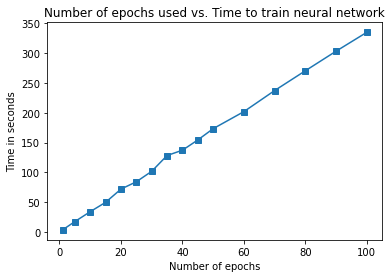

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

#Time spent plot
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList, timeList, marker='s')
plt.title("Number of epochs used vs. Time to train neural network")
plt.xlabel("Number of epochs")
plt.ylabel("Time in seconds")


#plt.legend(loc='upper left');
plt.show()

In [15]:
for epochElement, timeElement in zip(epochList, timeList):
    
    minuteValue = timeElement / 60
    
    print("Number of epochs:", epochElement)
    print("Time spent:", minuteValue, "minutes", '\n')

Number of epochs: 1
Time spent: 0.06047320365905762 minutes 

Number of epochs: 5
Time spent: 0.2928246736526489 minutes 

Number of epochs: 10
Time spent: 0.5692044615745544 minutes 

Number of epochs: 15
Time spent: 0.8303578813870748 minutes 

Number of epochs: 20
Time spent: 1.1999029080073038 minutes 

Number of epochs: 25
Time spent: 1.4045201857884726 minutes 

Number of epochs: 30
Time spent: 1.695838443438212 minutes 

Number of epochs: 35
Time spent: 2.1374362746874493 minutes 

Number of epochs: 40
Time spent: 2.285554317633311 minutes 

Number of epochs: 45
Time spent: 2.5716612060864765 minutes 

Number of epochs: 50
Time spent: 2.886790402730306 minutes 

Number of epochs: 60
Time spent: 3.363085722923279 minutes 

Number of epochs: 70
Time spent: 3.9514578183492026 minutes 

Number of epochs: 80
Time spent: 4.504183419545492 minutes 

Number of epochs: 90
Time spent: 5.051222312450409 minutes 

Number of epochs: 100
Time spent: 5.578487054506938 minutes 



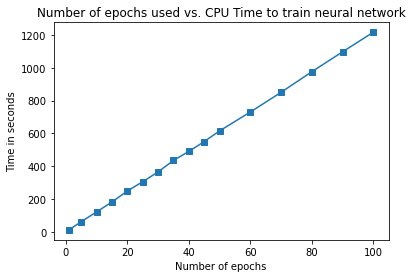

In [16]:
#CPU Time spent plot
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList, cpuTime, marker='s')
plt.title("Number of epochs used vs. CPU Time to train neural network")
plt.xlabel("Number of epochs")
plt.ylabel("Time in seconds")


#plt.legend(loc='upper left');
plt.show()

In [17]:
for epochElement, timeElement in zip(epochList, cpuTime):
    
    minuteValue = timeElement / 60
    
    print("Number of epochs:", epochElement)
    print("CPU Time spent:", minuteValue, "minutes", '\n')

Number of epochs: 1
CPU Time spent: 0.19800527761666667 minutes 

Number of epochs: 5
CPU Time spent: 1.0325818506833333 minutes 

Number of epochs: 10
CPU Time spent: 2.0278055020166668 minutes 

Number of epochs: 15
CPU Time spent: 3.034430066133334 minutes 

Number of epochs: 20
CPU Time spent: 4.146740762933334 minutes 

Number of epochs: 25
CPU Time spent: 5.091108892183333 minutes 

Number of epochs: 30
CPU Time spent: 6.086321888066667 minutes 

Number of epochs: 35
CPU Time spent: 7.2501438577 minutes 

Number of epochs: 40
CPU Time spent: 8.168869861366666 minutes 

Number of epochs: 45
CPU Time spent: 9.163104052750002 minutes 

Number of epochs: 50
CPU Time spent: 10.25361104356666 minutes 

Number of epochs: 60
CPU Time spent: 12.168895244783334 minutes 

Number of epochs: 70
CPU Time spent: 14.168602447733322 minutes 

Number of epochs: 80
CPU Time spent: 16.259604209350012 minutes 

Number of epochs: 90
CPU Time spent: 18.278054487483328 minutes 

Number of epochs: 100
CP

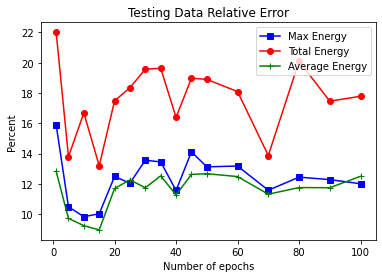

In [18]:
#Percent Error plot
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

startIndex = 0

plt.plot(epochList[startIndex:], maxEnergyPercent[startIndex:], c='b', marker="s", label='Max Energy')
plt.plot(epochList[startIndex:], totalEnergyPercent[startIndex:], c='r', marker="o", label='Total Energy')
plt.plot(epochList[startIndex:], avgEnergyPercent[startIndex:], c='g', marker='+', label='Average Energy')
plt.title("Testing Data Relative Error")
plt.xlabel("Number of epochs")
plt.ylabel("Percent")
plt.legend(loc='upper right')

data = {'Epochs': epochList[startIndex:], 
        'Max Energy': maxEnergyPercent[startIndex:]}
df = pd.DataFrame(data)

# Write DataFrame to CSV
df.to_csv('data_3hl'+str(batchSize) + str(numPoints)+'.csv', index=False)

plt.show()

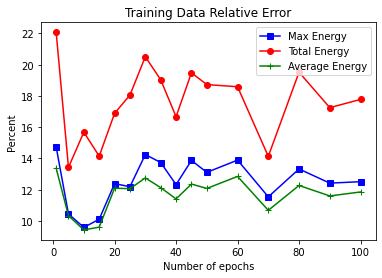

In [19]:
#Percent Error plot for training data
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList[startIndex:], trainMaxPercent[startIndex:], c='b', marker="s", label='Max Energy')
plt.plot(epochList[startIndex:], trainTotalPercent[startIndex:], c='r', marker="o", label='Total Energy')
plt.plot(epochList[startIndex:], trainAvgPercent[startIndex:], c='g', marker='+', label='Average Energy')
plt.title("Training Data Relative Error")
plt.xlabel("Number of epochs")
plt.ylabel("Percent")
plt.legend(loc='upper right')
plt.show()

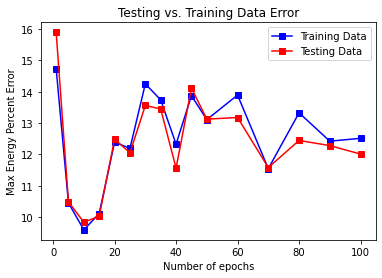

In [20]:
#Compare errors of train and test using just the max energy % error

fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList[startIndex:], trainMaxPercent[startIndex:], c='b', marker="s", label='Training Data')
plt.plot(epochList[startIndex:], maxEnergyPercent[startIndex:], c='r', marker="s", label='Testing Data')

plt.title("Testing vs. Training Data Error")
plt.xlabel("Number of epochs")
plt.ylabel("Max Energy Percent Error")
plt.legend(loc='upper right')
plt.show()

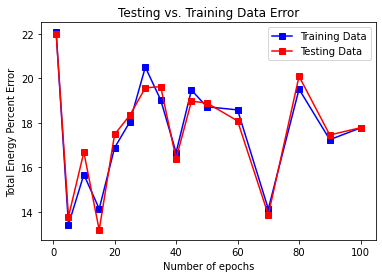

In [21]:
#Compare errors of train and test using just the total energy % error

fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList[startIndex:], trainTotalPercent[startIndex:], c='b', marker="s", label='Training Data')
plt.plot(epochList[startIndex:], totalEnergyPercent[startIndex:], c='r', marker="s", label='Testing Data')

plt.title("Testing vs. Training Data Error")
plt.xlabel("Number of epochs")
plt.ylabel("Total Energy Percent Error")
plt.legend(loc='upper right')
plt.show()

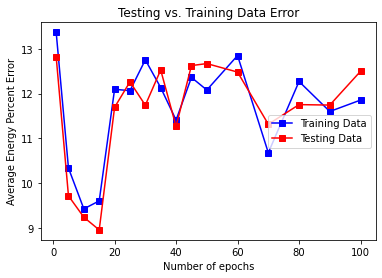

In [22]:
#Compare errors of train and test using just the avg energy % error

fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList[startIndex:], trainAvgPercent[startIndex:], c='b', marker="s", label='Training Data')
plt.plot(epochList[startIndex:], avgEnergyPercent[startIndex:], c='r', marker="s", label='Testing Data')

plt.title("Testing vs. Training Data Error")
plt.xlabel("Number of epochs")
plt.ylabel("Average Energy Percent Error")
plt.legend(loc='center right')
plt.show()

In [23]:
for epoch, maxError, totalError, avgError in zip(epochList, maxEnergyPercent, totalEnergyPercent, avgEnergyPercent):
    print("Number of epochs:", epoch)
    print("Max energy percent error:", maxError)
    print("Total energy percent error:", totalError)
    print("Average energy percent error:", avgError, '\n')

Number of epochs: 1
Max energy percent error: 15.899848798844786
Total energy percent error: 22.01461791388158
Average energy percent error: 12.822606898523631 

Number of epochs: 5
Max energy percent error: 10.483958839972779
Total energy percent error: 13.789007335988108
Average energy percent error: 9.718309972594447 

Number of epochs: 10
Max energy percent error: 9.832440499909973
Total energy percent error: 16.68613834555088
Average energy percent error: 9.241054446318069 

Number of epochs: 15
Max energy percent error: 10.024888821231265
Total energy percent error: 13.195810870253226
Average energy percent error: 8.958084488625378 

Number of epochs: 20
Max energy percent error: 12.487515066973298
Total energy percent error: 17.482459089242333
Average energy percent error: 11.693798937140746 

Number of epochs: 25
Max energy percent error: 12.048328260348477
Total energy percent error: 18.354230322442373
Average energy percent error: 12.263328020085893 

Number of epochs: 30
Max

Text(0, 0.5, 'Average Energy Error (MeV)')

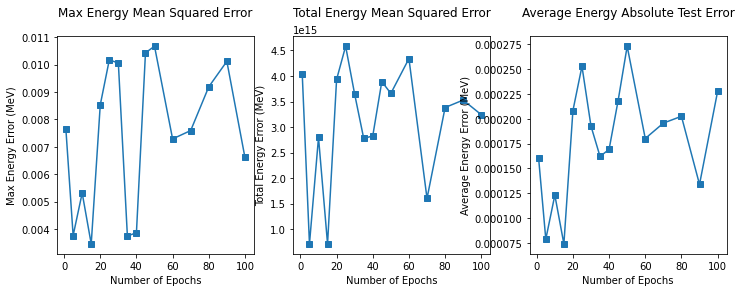

In [24]:
fig = plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochList[startIndex:], maxEnergyMSE[startIndex:], marker = 's')
plt.title("Max Energy Mean Squared Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Max Energy Error (MeV)')

plt.subplot(1, 3, 2)
plt.plot(epochList[startIndex:], totalEnergyMSE[startIndex:], marker = 's')
plt.title("Total Energy Mean Squared Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Total Energy Error (MeV)')

plt.subplot(1, 3, 3)
plt.plot(epochList[startIndex:], avgEnergyMSE[startIndex:], marker = 's')
plt.title("Average Energy Absolute Test Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Average Energy Error (MeV)')

Text(0, 0.5, 'Average Energy Error (MeV)')

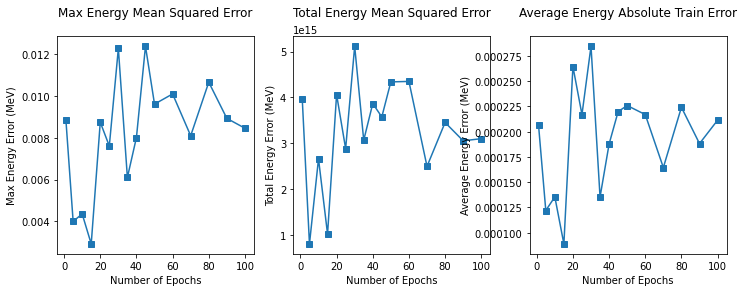

In [25]:
fig = plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochList[startIndex:], trainMaxMSE[startIndex:], marker='s')
plt.title("Max Energy Mean Squared Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Max Energy Error (MeV)')

plt.subplot(1, 3, 2)
plt.plot(epochList[startIndex:], trainTotalMSE[startIndex:], marker='s')
plt.title("Total Energy Mean Squared Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Total Energy Error (MeV)')

plt.subplot(1, 3, 3)
plt.plot(epochList[startIndex:], trainAvgMSE[startIndex:], marker='s')
plt.title("Average Energy Absolute Train Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Average Energy Error (MeV)')

In [26]:
def listSubtract(list1, list2):
    result = []
    
    for x, y in zip(list1, list2):
        difference = x - y
        difference = abs(difference)
        result.append(difference)
        
    
    return result

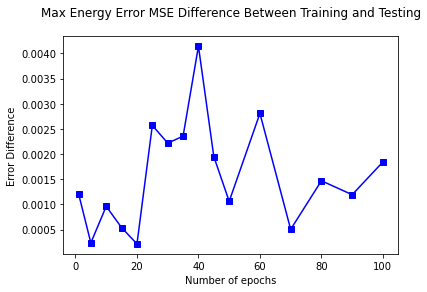

In [27]:
#Compare train and test MSE errors on the max energy

fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1)

maxMSEDiff = listSubtract(trainMaxMSE, maxEnergyMSE)

plt.plot(epochList[startIndex:], maxMSEDiff[startIndex:], c='b', marker="s")

plt.title("Max Energy Error MSE Difference Between Training and Testing", pad = 20)
plt.xlabel("Number of epochs")
plt.ylabel("Error Difference")
#plt.legend(loc='upper left')
plt.show()

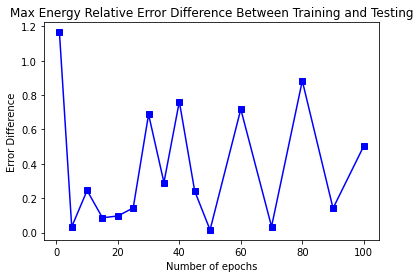

In [28]:
#Compare train and test percent errors on the max energy

fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1)

maxPercentDiff = listSubtract(trainMaxPercent, maxEnergyPercent)

plt.plot(epochList[startIndex:], maxPercentDiff[startIndex:], c='b', marker="s")

plt.title("Max Energy Relative Error Difference Between Training and Testing")
plt.xlabel("Number of epochs")
plt.ylabel("Error Difference")
#plt.legend(loc='upper left')
plt.show()

In [29]:
for epoch, maxError, totalError, avgError in zip(epochList, maxEnergyMSE, totalEnergyMSE, avgEnergyMSE):
    print("Number of epochs:", epoch)
    print("Max energy MSE:", maxError)
    print("Total energy MSE:", totalError)
    print("Average energy MSE:", avgError, '\n')

Number of epochs: 1
Max energy MSE: 0.007634947310879503
Total energy MSE: 4042676979293346.5
Average energy MSE: 0.00016094935593849395 

Number of epochs: 5
Max energy MSE: 0.0037638583431638677
Total energy MSE: 709341896473735.4
Average energy MSE: 7.900898680672557e-05 

Number of epochs: 10
Max energy MSE: 0.005315256113161293
Total energy MSE: 2795586671376444.0
Average energy MSE: 0.00012329450877929257 

Number of epochs: 15
Max energy MSE: 0.0034573229655592698
Total energy MSE: 708871729255510.5
Average energy MSE: 7.428518773912306e-05 

Number of epochs: 20
Max energy MSE: 0.008531633796824815
Total energy MSE: 3932567554055010.5
Average energy MSE: 0.00020815399700025488 

Number of epochs: 25
Max energy MSE: 0.010174009787278589
Total energy MSE: 4583403573966084.0
Average energy MSE: 0.00025264710181766026 

Number of epochs: 30
Max energy MSE: 0.010056007605710338
Total energy MSE: 3641594610425482.0
Average energy MSE: 0.0001924709140339544 

Number of epochs: 35
Max 